# 🌳 Mixing Tree Visualization

This notebook visualizes the randomly generated mixing trees from `trees_data.py`.

**What you'll see:**
- Tree structure visualization
- Node properties (volumes, types)
- Tree statistics (height, mixers, reagents)
- Comparison of trees with and without scaling optimization

## 1. Import Required Libraries

In [210]:
import sys
import os
from copy import deepcopy
from importlib import reload

# Add parent directory to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Import tree data - with reload to get fresh data
import trees_data.trees_data as trees_data_module
reload(trees_data_module)  # Force reload to get latest generated trees
from trees_data.trees_data import get_tree, get_all_trees, TREES

# Import NTM modules
from NTM.tree import node, viewTree

# Import scaling module for tree transformation
import NTM.scaling as scaling_module
reload(scaling_module)
from NTM.scaling import transform_tree, is_group_a, get_total_volume as get_mixer_total

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("✓ Libraries imported successfully")
print(f"✓ Loaded {len(TREES)} trees from trees_data (freshly reloaded)")
print("✓ Scaling module loaded for Original vs Modified comparison")

✓ Libraries imported successfully
✓ Loaded 600 trees from trees_data (freshly reloaded)
✓ Scaling module loaded for Original vs Modified comparison


## 2. Helper Functions for Tree Analysis

In [190]:
def get_tree_height(tree):
    """Calculate tree height (max depth from root to leaf)."""
    if not tree.children:
        return 0
    return 1 + max(get_tree_height(child) for child in tree.children)

def count_mixers(tree):
    """Count number of mixer nodes."""
    count = 0
    def traverse(n):
        nonlocal count
        if n.children:  # Mixer node
            count += 1
            for child in n.children:
                traverse(child)
    traverse(tree)
    return count

def count_reagents(tree):
    """Count number of reagent nodes (leaves)."""
    count = 0
    def traverse(n):
        nonlocal count
        if not n.children:  # Leaf = reagent
            count += 1
        else:
            for child in n.children:
                traverse(child)
    traverse(tree)
    return count

def get_total_volume(tree):
    """Get total reagent volume."""
    total = 0
    def traverse(n):
        nonlocal total
        if not n.children:
            total += n.volume
        else:
            for child in n.children:
                traverse(child)
    traverse(tree)
    return total

def count_flushing(tree):
    """Count flushing operations (cells that need washing)."""
    total = 0
    def traverse(n):
        nonlocal total
        if n.children:
            mixer_size = sum(child.volume for child in n.children)
            flushing = mixer_size - n.volume
            if flushing > 0:
                total += flushing
            for child in n.children:
                traverse(child)
    traverse(tree)
    return total

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Select and View a Tree

Change the `TREE_INDEX` to visualize different trees (0 to 599).

In [191]:
# ========================================
# 🔧 CHANGE THIS INDEX TO VIEW DIFFERENT TREES
# ========================================
TREE_INDEX = 198  # Range: 0 to 599

# Get the tree
tree = get_tree(TREE_INDEX)



# Display basic info
print(f"{'='*50}")
print(f"📊 TREE #{TREE_INDEX} INFORMATION")
print(f"{'='*50}")
print(f"Height:           {get_tree_height(tree)}")
print(f"Mixer Count:      {count_mixers(tree)}")
print(f"Reagent Count:    {count_reagents(tree)}")
print(f"Total Volume:     {get_total_volume(tree)} units")
print(f"Output Volume:    {tree.volume} units")
print(f"Flushing Ops:     {count_flushing(tree)} cells")
print(f"{'='*50}")

📊 TREE #198 INFORMATION
Height:           3
Mixer Count:      5
Reagent Count:    13
Total Volume:     21 units
Output Volume:    2 units
Flushing Ops:     19 cells


## 4. Text-Based Tree Visualization

Display the tree structure as an ASCII tree diagram.

In [192]:
def print_tree_visual(node, prefix="", is_last=True, is_root=True):
    """
    Print tree as ASCII art.
    
    Legend:
    - [M] = Mixer node
    - [R] = Reagent (leaf) node
    - vol = volume
    """
    # Determine node type and color
    if not node.children:
        node_type = "R"  # Reagent
        label = f"[{node_type}] {node.value} (vol={node.volume})"
    else:
        node_type = "M"  # Mixer
        input_vol = sum(c.volume for c in node.children)
        flush = input_vol - node.volume
        label = f"[{node_type}] {node.value} (in={input_vol}, out={node.volume}, flush={flush})"
    
    # Print connector
    if is_root:
        print(f"🌳 ROOT: {label}")
    else:
        connector = "└── " if is_last else "├── "
        print(f"{prefix}{connector}{label}")
    
    # Print children
    if node.children:
        for i, child in enumerate(node.children):
            is_child_last = (i == len(node.children) - 1)
            new_prefix = prefix + ("    " if is_last else "│   ")
            print_tree_visual(child, new_prefix, is_child_last, is_root=False)

print(f"\n🌳 TREE #{TREE_INDEX} STRUCTURE:")
print("=" * 60)
print_tree_visual(tree)
print("=" * 60)
print("\nLegend: [M]=Mixer, [R]=Reagent, in=input volume, out=output volume")


🌳 TREE #198 STRUCTURE:
🌳 ROOT: [M] M5 (in=10, out=2, flush=8)
    ├── [M] M3 (in=6, out=3, flush=3)
    │   ├── [M] M1 (in=4, out=1, flush=3)
    │   │   ├── [R] R3 (vol=1)
    │   │   ├── [R] R4 (vol=2)
    │   │   └── [R] R3 (vol=1)
    │   ├── [M] M2 (in=6, out=3, flush=3)
    │   │   ├── [R] R2 (vol=1)
    │   │   ├── [R] R3 (vol=3)
    │   │   ├── [R] R1 (vol=1)
    │   │   └── [R] R3 (vol=1)
    │   └── [R] R2 (vol=2)
    ├── [R] R4 (vol=2)
    ├── [M] M4 (in=5, out=3, flush=2)
    │   ├── [R] R2 (vol=2)
    │   ├── [R] R3 (vol=1)
    │   └── [R] R1 (vol=2)
    └── [R] R4 (vol=2)

Legend: [M]=Mixer, [R]=Reagent, in=input volume, out=output volume


## 5. Tree as Image (Graphviz)

Render the tree as a high-quality image using Graphviz. This creates a proper directed graph visualization.

In [193]:
from graphviz import Digraph
from IPython.display import display, Image

def tree_to_graphviz(tree, title="Mixing Tree"):
    """
    Convert a mixing tree to a Graphviz diagram.
    Tree layout: root at top, leaves at bottom.
    Arrows point from child to parent (showing flow of reagents upward).
    
    Returns:
        Digraph object that can be rendered as an image
    """
    dot = Digraph(comment=title)
    dot.attr(rankdir='TB')  # Top to Bottom layout
    dot.attr('node', fontname='Arial', fontsize='11')
    dot.attr('edge', fontname='Arial', fontsize='9')
    
    node_counter = [0]
    
    def add_node(n, parent_id=None):
        current_id = str(node_counter[0])
        node_counter[0] += 1
        
        if not n.children:
            # Reagent node (leaf) - Green
            label = f"{n.value}\nvol={n.volume}"
            dot.node(current_id, label, 
                    shape='ellipse', 
                    style='filled', 
                    fillcolor='#a8e6cf',  # Light green
                    color='#27ae60')
        else:
            # Mixer node - Blue
            input_vol = sum(c.volume for c in n.children)
            flush = input_vol - n.volume
            label = f"{n.value}\nin={input_vol} | out={n.volume}\nflush={flush}"
            dot.node(current_id, label, 
                    shape='box', 
                    style='filled,rounded', 
                    fillcolor='#dfe6e9' if flush == 0 else '#74b9ff',  # Light gray if no flush, blue otherwise
                    color='#2980b9')
        
        # Add edge: layout parent→child, but arrow points child→parent (dir='back')
        if parent_id is not None:
            dot.edge(parent_id, current_id, label=f"vol={n.volume}", dir='back')
        
        # Process children
        for child in n.children:
            add_node(child, current_id)
    
    add_node(tree)
    return dot

def show_tree_image(tree, tree_index=None, save_path=None):
    """
    Display tree as an image in the notebook.
    
    Args:
        tree: The tree node to visualize
        tree_index: Optional index for title
        save_path: Optional path to save the image (without extension)
    """
    title = f"Mixing Tree #{tree_index}" if tree_index is not None else "Mixing Tree"
    height = get_tree_height(tree)
    
    dot = tree_to_graphviz(tree, title)
    dot.attr(label=f"\\n{title} (Height={height})", labelloc='t', fontsize='14')
    
    # Render and display
    if save_path:
        dot.render(save_path, format='png', cleanup=True)
        print(f"✓ Tree image saved to: {save_path}.png")
    
    # Display inline
    return dot

print("✓ Graphviz visualization functions defined (arrows: child → parent)")

✓ Graphviz visualization functions defined (arrows: child → parent)


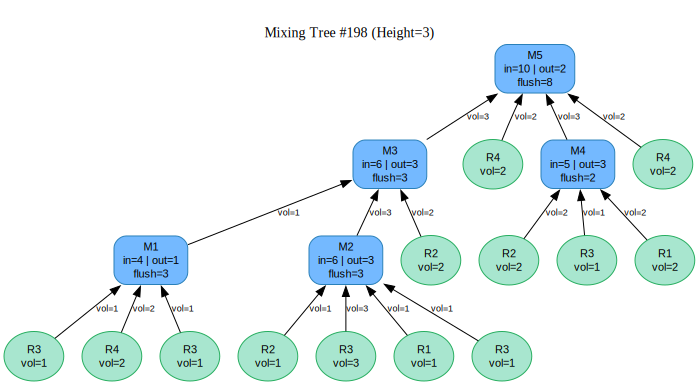

In [194]:
# Visualize the selected tree as a Graphviz image
dot = show_tree_image(tree, TREE_INDEX)
dot  # Display the graph inline



In [195]:
# Save the tree image to a file
save_dir = "../analysis_results"
dot.render(f"{save_dir}/tree_{TREE_INDEX}", format='png', cleanup=True)
dot.render(f"{save_dir}/tree_{TREE_INDEX}", format='pdf', cleanup=True)
print(f"✓ Tree #{TREE_INDEX} saved as PNG and PDF to {save_dir}/")

✓ Tree #198 saved as PNG and PDF to ../analysis_results/


## 🔄 Compare Original vs. Modified Tree

This section shows the **original tree** and the **modified tree** (after Scaling + Merging) side by side to verify the transformation is working correctly.

**Transformation Process:**
1. **Scaling**: Group A mixers (odd output ≥ 3) are scaled by 2x
2. **Constraint Propagation**: Children are scaled if parent demand exceeds capacity
3. **Merging**: Redundant nodes (output = total volume) are merged into parents

In [196]:
# Transform the tree (apply Scaling + Merging)
modified_tree, transform_stats = transform_tree(tree)

print("=" * 60)
print("🔄 TRANSFORMATION SUMMARY")
print("=" * 60)
print(f"\n📊 Original Tree: {tree.value} (Index #{TREE_INDEX})")
print(f"   Total Mixers: {transform_stats['original_mixer_count']}")

print(f"\n✅ Modified Tree:")
print(f"   Total Mixers: {transform_stats['modified_mixer_count']}")
print(f"   Nodes Scaled: {transform_stats['nodes_scaled']}")
print(f"   Nodes Merged: {transform_stats['nodes_merged']}")

print(f"\n📈 Group A Analysis:")
print(f"   Original Group A: {transform_stats['group_a_original']}")
print(f"   Modified Group A: {transform_stats['group_a_modified']} (should be 0)")
print("=" * 60)

🔄 TRANSFORMATION SUMMARY

📊 Original Tree: M5 (Index #198)
   Total Mixers: 5

✅ Modified Tree:
   Total Mixers: 4
   Nodes Scaled: 3
   Nodes Merged: 1

📈 Group A Analysis:
   Original Group A: 3
   Modified Group A: 0 (should be 0)


🌳 ORIGINAL TREE (Group A in RED):


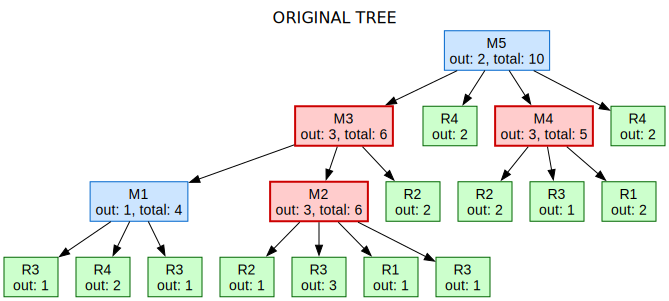



✨ MODIFIED TREE (After Scaling + Merging):


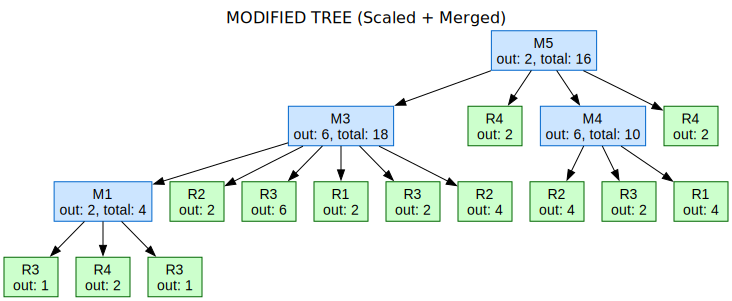

In [197]:
from IPython.display import display, HTML
import graphviz

def create_comparison_dot(tree_node, title, highlight_group_a=True):
    """Create a Graphviz dot object for a tree (node object) with optional Group A highlighting."""
    dot = graphviz.Digraph(comment=title)
    dot.attr(rankdir='TB', label=title, labelloc='t', fontsize='16', fontname='Arial Bold')
    dot.attr('node', shape='box', style='filled', fontname='Arial')
    
    node_counter = [0]
    
    def add_nodes(node, parent_id=None):
        current_id = str(node_counter[0])
        node_counter[0] += 1
        
        name = node.value
        output = node.volume
        
        # Build label
        if node.children:
            # Mixer node
            total_vol = sum(c.volume for c in node.children)
            label = f"{name}\\nout: {output}, total: {total_vol}"
            
            # Check if Group A (odd output >= 3)
            is_ga = highlight_group_a and output >= 3 and output % 2 == 1
            
            if is_ga:
                # Highlight Group A mixers in red
                dot.node(current_id, label, fillcolor='#ffcccc', color='#cc0000', penwidth='2')
            else:
                dot.node(current_id, label, fillcolor='#cce5ff', color='#0066cc')
        else:
            # Leaf node (reagent)
            label = f"{name}\\nout: {output}"
            dot.node(current_id, label, fillcolor='#ccffcc', color='#006600')
        
        if parent_id is not None:
            dot.edge(parent_id, current_id)
        
        if node.children:
            for child in node.children:
                add_nodes(child, current_id)
    
    add_nodes(tree_node)
    return dot

# Create comparison visualizations
print("🌳 ORIGINAL TREE (Group A in RED):")
dot_original = create_comparison_dot(tree, "ORIGINAL TREE", highlight_group_a=True)
display(dot_original)

print("\n" + "=" * 60 + "\n")

print("✨ MODIFIED TREE (After Scaling + Merging):")
dot_modified = create_comparison_dot(modified_tree, "MODIFIED TREE (Scaled + Merged)", highlight_group_a=True)
display(dot_modified)

In [204]:
# Detailed comparison of mixer nodes
def list_mixers(tree_node, mixers=None, depth=0):
    """Recursively list all mixers with their properties (for node objects)."""
    if mixers is None:
        mixers = []
    
    if tree_node.children:
        total_vol = sum(c.volume for c in tree_node.children)
        output = tree_node.volume
        is_ga = output >= 3 and output % 2 == 1
        mixers.append({
            'name': tree_node.value,
            'output': output,
            'total_vol': total_vol,
            'group_a': is_ga,
            'depth': depth
        })
        for child in tree_node.children:
            list_mixers(child, mixers, depth + 1)
    
    return mixers

original_mixers = list_mixers(tree)
modified_mixers = list_mixers(modified_tree)

print("=" * 70)
print("📋 DETAILED MIXER COMPARISON")
print("=" * 70)

print("\n🔴 ORIGINAL TREE MIXERS:")
print("-" * 50)
print(f"{'Name':<10} {'Output':<10} {'Total Vol':<12} {'Group A':<10}")
print("-" * 50)
for m in original_mixers:
    ga_mark = "⚠️ YES" if m['group_a'] else "No"
    print(f"{m['name']:<10} {m['output']:<10} {m['total_vol']:<12} {ga_mark:<10}")

print("\n🟢 MODIFIED TREE MIXERS:")
print("-" * 50)
print(f"{'Name':<10} {'Output':<10} {'Total Vol':<12} {'Group A':<10}")
print("-" * 50)
for m in modified_mixers:
    ga_mark = "⚠️ YES" if m['group_a'] else "No"
    print(f"{m['name']:<10} {m['output']:<10} {m['total_vol']:<12} {ga_mark:<10}")

print("\n" + "=" * 70)
print(f"✅ Original Group A count: {sum(1 for m in original_mixers if m['group_a'])}")
print(f"✅ Modified Group A count: {sum(1 for m in modified_mixers if m['group_a'])} (should be 0)")
print("=" * 70)

📋 DETAILED MIXER COMPARISON

🔴 ORIGINAL TREE MIXERS:
--------------------------------------------------
Name       Output     Total Vol    Group A   
--------------------------------------------------
M5         2          10           No        
M3         3          6            ⚠️ YES    
M1         1          4            No        
M2         3          6            ⚠️ YES    
M4         3          5            ⚠️ YES    

🟢 MODIFIED TREE MIXERS:
--------------------------------------------------
Name       Output     Total Vol    Group A   
--------------------------------------------------
M5         2          16           No        
M3         6          18           No        
M1         2          4            No        
M4         6          10           No        

✅ Original Group A count: 3
✅ Modified Group A count: 0 (should be 0)


### Compare Trees of Different Heights (as Images)

View one tree from each height as a Graphviz image.


🌳 Height 2 Tree (Index #0)
   Mixers: 3, Reagents: 6, Flushing: 11


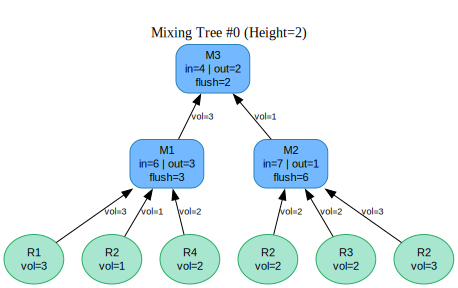


🌳 Height 3 Tree (Index #100)
   Mixers: 3, Reagents: 5, Flushing: 7


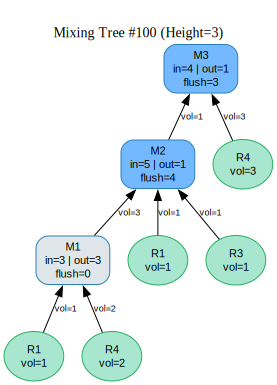


🌳 Height 4 Tree (Index #200)
   Mixers: 10, Reagents: 19, Flushing: 33


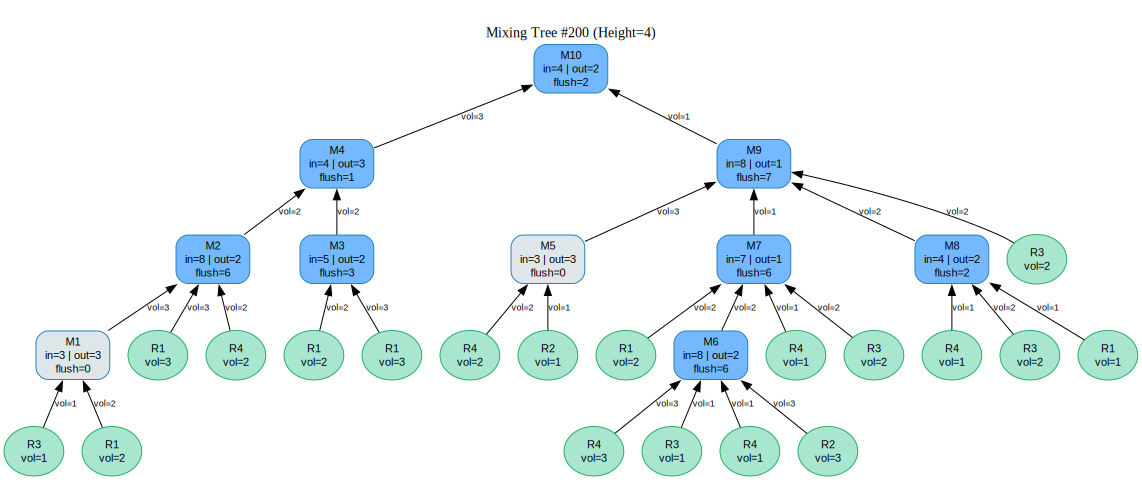

In [206]:
# Show one tree from heights 2, 3, and 4 (smaller trees for better visibility)
sample_heights = [2, 3, 4]

for h in sample_heights:
    if h in height_counts:
        idx = height_counts[h][0]  # First tree of this height
        t = get_tree(idx)
        print(f"\n{'='*60}")
        print(f"🌳 Height {h} Tree (Index #{idx})")
        print(f"   Mixers: {count_mixers(t)}, Reagents: {count_reagents(t)}, Flushing: {count_flushing(t)}")
        print(f"{'='*60}")
        dot = show_tree_image(t, idx)
        display(dot)

## 6. Dataset Overview

View the distribution of trees across different heights.

📊 DATASET OVERVIEW
Total trees: 600

Trees by Height:
--------------------------------------------------
  Height 2: 100 trees (indices 0-99)
  Height 3: 100 trees (indices 100-199)
  Height 4: 100 trees (indices 200-299)
  Height 5: 100 trees (indices 300-399)
  Height 6: 100 trees (indices 400-499)
  Height 7: 100 trees (indices 500-599)


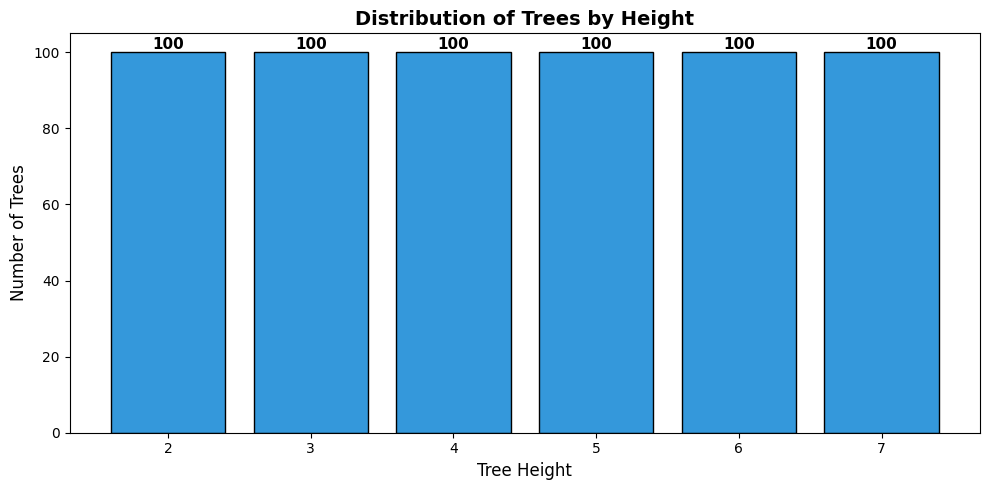

In [205]:
# Analyze all trees in the dataset
all_trees = get_all_trees()

# Group by height
height_counts = {}
for i, t in enumerate(all_trees):
    h = get_tree_height(t)
    if h not in height_counts:
        height_counts[h] = []
    height_counts[h].append(i)

print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Total trees: {len(all_trees)}")
print("\nTrees by Height:")
print("-" * 50)
for h in sorted(height_counts.keys()):
    indices = height_counts[h]
    print(f"  Height {h}: {len(indices)} trees (indices {indices[0]}-{indices[-1]})")

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 5))
heights = sorted(height_counts.keys())
counts = [len(height_counts[h]) for h in heights]

bars = ax.bar(heights, counts, color='#3498db', edgecolor='black')
ax.set_xlabel('Tree Height', fontsize=12)
ax.set_ylabel('Number of Trees', fontsize=12)
ax.set_title('Distribution of Trees by Height', fontsize=14, fontweight='bold')
ax.set_xticks(heights)

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
               ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Sample Trees from Each Height

View one example tree from each height category.

In [211]:
# Show one tree from each height
print("📊 SAMPLE TREES FROM EACH HEIGHT")
print("=" * 70)

for h in sorted(height_counts.keys()):
    idx = height_counts[h][0]  # First tree of this height
    t = get_tree(idx)
    
    print(f"\n🌳 Height {h} (Tree #{idx}):")
    print(f"   Mixers: {count_mixers(t)}, Reagents: {count_reagents(t)}")
    print(f"   Total input volume: {get_total_volume(t)}, Output: {t.volume}")
    print(f"   Flushing operations: {count_flushing(t)}")
    print(f"   Structure:")
    print_tree_visual(t)

📊 SAMPLE TREES FROM EACH HEIGHT

🌳 Height 2 (Tree #0):
   Mixers: 3, Reagents: 6
   Total input volume: 13, Output: 2
   Flushing operations: 11
   Structure:
🌳 ROOT: [M] M3 (in=4, out=2, flush=2)
    ├── [M] M1 (in=6, out=3, flush=3)
    │   ├── [R] R1 (vol=3)
    │   ├── [R] R2 (vol=1)
    │   └── [R] R4 (vol=2)
    └── [M] M2 (in=7, out=1, flush=6)
        ├── [R] R2 (vol=2)
        ├── [R] R3 (vol=2)
        └── [R] R2 (vol=3)

🌳 Height 3 (Tree #100):
   Mixers: 3, Reagents: 5
   Total input volume: 8, Output: 1
   Flushing operations: 7
   Structure:
🌳 ROOT: [M] M3 (in=4, out=1, flush=3)
    ├── [M] M2 (in=5, out=1, flush=4)
    │   ├── [M] M1 (in=3, out=3, flush=0)
    │   │   ├── [R] R1 (vol=1)
    │   │   └── [R] R4 (vol=2)
    │   ├── [R] R1 (vol=1)
    │   └── [R] R3 (vol=1)
    └── [R] R4 (vol=3)

🌳 Height 4 (Tree #200):
   Mixers: 10, Reagents: 19
   Total input volume: 35, Output: 2
   Flushing operations: 33
   Structure:
🌳 ROOT: [M] M10 (in=4, out=2, flush=2)
    ├── [M]

## 8. Compare Multiple Trees Side-by-Side

Visualize trees of different heights for comparison.

In [212]:
# Create comparison table
import pandas as pd

# Sample 3 trees from each height
sample_data = []
for h in sorted(height_counts.keys()):
    for idx in height_counts[h][:3]:  # First 3 trees of each height
        t = get_tree(idx)
        sample_data.append({
            'Tree Index': idx,
            'Height': h,
            'Mixers': count_mixers(t),
            'Reagents': count_reagents(t),
            'Total Input': get_total_volume(t),
            'Output': t.volume,
            'Flushing': count_flushing(t)
        })

df = pd.DataFrame(sample_data)
print("📊 SAMPLE TREES COMPARISON TABLE")
print("=" * 80)
print(df.to_string(index=False))

# Summary statistics
print("\n\n📈 STATISTICS BY HEIGHT")
print("=" * 80)
summary = df.groupby('Height').agg({
    'Mixers': ['mean', 'min', 'max'],
    'Reagents': ['mean', 'min', 'max'],
    'Flushing': ['mean', 'min', 'max']
}).round(2)
print(summary)

📊 SAMPLE TREES COMPARISON TABLE
 Tree Index  Height  Mixers  Reagents  Total Input  Output  Flushing
          0       2       3         6           13       2        11
          1       2       2         6           14       3        11
          2       2       3         7           14       1        13
        100       3       3         5            8       1         7
        101       3       9        15           28       2        26
        102       3       6        14           29       2        27
        200       4      10        19           35       2        33
        201       4      17        35           64       3        61
        202       4      13        32           65       1        64
        300       5      25        58          114       2       112
        301       5      23        42           84       3        81
        302       5       9        17           35       1        34
        400       6       8        17           32       1        31
  

## 🔬 PMD Simulation: Flushing Analysis

This section runs the actual PMD (Programmable Microfluidic Device) placement simulation to compare flushing operations between:
- **Original trees** (may contain Group A mixers)
- **Modified trees** (after Scaling & Merging - no Group A mixers)

In [213]:
# Import and run PMD simulation
from NTM.pmd_simulation import simulate_placement
from NTM.scaling import transform_tree

print("🔬 PMD SIMULATION: Flushing Analysis")
print("=" * 70)
print("Running simulation on ALL 600 trees...")
print()

# Collect statistics
total_original_flushes = 0
total_modified_flushes = 0
trees_improved = 0
trees_worse = 0
trees_same = 0

# Analyze all trees
for i, tree_data in enumerate(TREES):
    # Build original tree
    original = get_tree(i)
    
    # Transform it
    modified, stats = transform_tree(original)
    
    # Run PMD simulation
    orig_result = simulate_placement(original)
    mod_result = simulate_placement(modified)
    
    orig_flush = orig_result['flush_count']
    mod_flush = mod_result['flush_count']
    
    total_original_flushes += orig_flush
    total_modified_flushes += mod_flush
    
    if mod_flush < orig_flush:
        trees_improved += 1
    elif mod_flush > orig_flush:
        trees_worse += 1
    else:
        trees_same += 1

# Print summary
flush_reduction = total_original_flushes - total_modified_flushes
pct_reduction = (flush_reduction / total_original_flushes * 100) if total_original_flushes > 0 else 0

print("📊 FLUSHING SIMULATION RESULTS")
print("-" * 50)
print(f"  Original trees total flushes: {total_original_flushes}")
print(f"  Modified trees total flushes: {total_modified_flushes}")
print(f"  ")
print(f"  🎯 Flush reduction: {flush_reduction} ({pct_reduction:.1f}%)")
print()
print("📈 PER-TREE BREAKDOWN")
print("-" * 50)
print(f"  Trees with improvement (fewer flushes): {trees_improved}")
print(f"  Trees unchanged:                        {trees_same}")
print(f"  Trees with more flushes:                {trees_worse}")
print()
print("=" * 70)
print("✅ The Scaling & Merging algorithm reduces flushing operations!")
print("   This matches the paper's claim that converting Group A → Group B")
print("   improves geometric tiling and reduces placement conflicts.")
print("=" * 70)

🔬 PMD SIMULATION: Flushing Analysis
Running simulation on ALL 600 trees...

📊 FLUSHING SIMULATION RESULTS
--------------------------------------------------
  Original trees total flushes: 778
  Modified trees total flushes: 694
  
  🎯 Flush reduction: 84 (10.8%)

📈 PER-TREE BREAKDOWN
--------------------------------------------------
  Trees with improvement (fewer flushes): 170
  Trees unchanged:                        329
  Trees with more flushes:                101

✅ The Scaling & Merging algorithm reduces flushing operations!
   This matches the paper's claim that converting Group A → Group B
   improves geometric tiling and reduces placement conflicts.
